In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [2]:
df = pd.read_csv('Frozen_Dessert_Production.csv',parse_dates=True,index_col='DATE')
df.columns = ['Production']

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [4]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


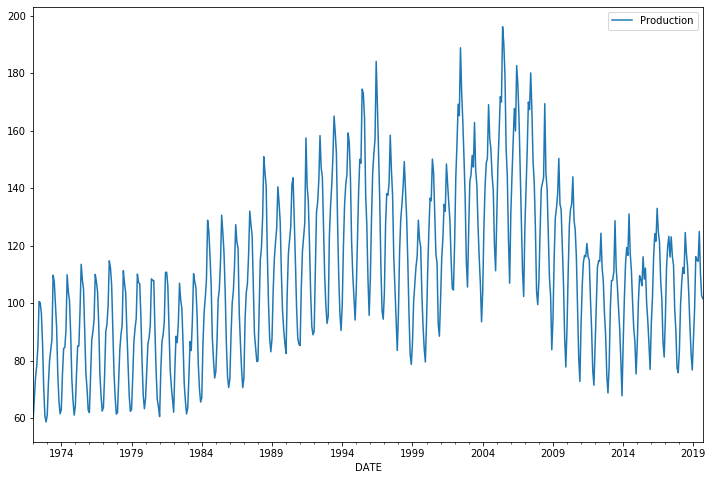

In [5]:
df.plot(figsize=(12,8))

## Train and Test Split

In [6]:
test_size = 24
test_index = len(df) - test_size
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [7]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
length = 18 
generator = TimeseriesGenerator(scaled_train,scaled_train,
                                batch_size=1,length=length)

## Model

In [9]:
n_features = 1
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [11]:
generator_valid = TimeseriesGenerator(scaled_test,scaled_test,
                                      length=length,batch_size=1)

In [12]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [13]:
model.fit_generator(generator,epochs=10,
                    validation_data=generator_valid,
                    callbacks=[early_stop])

Epoch 1/10
531/531 [==============================] - 29s 55ms/step - loss: 0.0289 - val_loss: 0.0044
Epoch 2/10
531/531 [==============================] - 30s 56ms/step - loss: 0.0102 - val_loss: 0.0014
Epoch 3/10
531/531 [==============================] - 29s 55ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 4/10
531/531 [==============================] - 31s 59ms/step - loss: 0.0033 - val_loss: 0.0030


In [14]:
losses = pd.DataFrame(model.history.history)

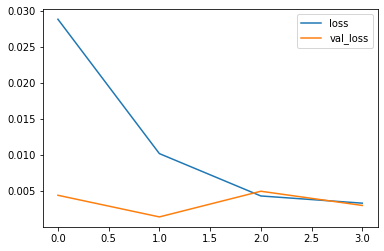

In [15]:
losses.plot()

In [38]:
def test_pred(train_df,size,n_features,length):

    test_predictions = []
    first_eval_batch = train_df[-length:]
    current_batch = first_eval_batch.reshape((1,length,n_features))

    for i in range(size):

        pred = model.predict(current_batch)[0]
        test_predictions.append(pred)
        current_batch = np.append(current_batch[:,1:,:],[[pred]],axis=1)
    
    return test_predictions

In [39]:
test_predictions = test_pred(scaled_train,len(test),n_features,length)
true_predictions = scaler.inverse_transform(test_predictions)

In [44]:
test['Predictions'] = true_predictions

C:\Users\sermengi\Anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
test.head()

,Production,Predictions
DATE,,
2017-10-01,90.4732,83.152475
2017-11-01,77.4378,76.439630
2017-12-01,75.8118,78.933249
2018-01-01,83.4343,87.611093
2018-02-01,99.4899,95.537132


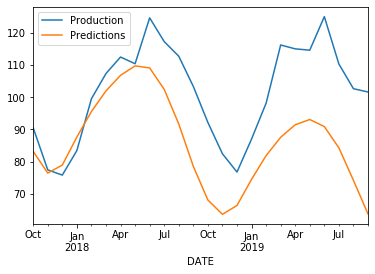

In [47]:
test.plot()

In [77]:
np.sqrt(mean_squared_error(test['Predictions'],test['Production']))

19.416686797970687

## Future Prediction

In [55]:
full_scaler = MinMaxScaler()
df_full_scaled = full_scaler.fit_transform(df)

In [56]:
generator = TimeseriesGenerator(df_full_scaled,df_full_scaled,
                                batch_size=1,length=length)

In [57]:
n_features = 1
model = Sequential()

model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [58]:
model.fit_generator(generator,epochs=4)

Epoch 1/4
555/555 [==============================] - 32s 57ms/step - loss: 0.0301
Epoch 2/4
555/555 [==============================] - 31s 56ms/step - loss: 0.0143
Epoch 3/4
555/555 [==============================] - 32s 58ms/step - loss: 0.0050
Epoch 4/4
555/555 [==============================] - 30s 54ms/step - loss: 0.0039


In [70]:
period = 24
forecast = test_pred(df_full_scaled,period,n_features,length)
forecast = full_scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2019-10-01',periods=period,
                               freq='MS')

In [71]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [72]:
df_forecast = pd.DataFrame(forecast,index=forecast_index,
                           columns=['Forecast'])

(576, 620)

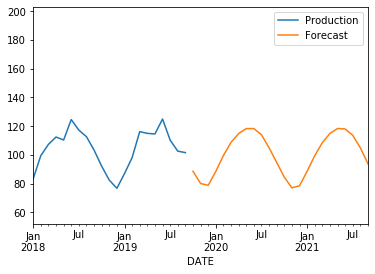

In [73]:
ax = df.plot()
df_forecast.plot(ax=ax)
plt.xlim('2018-01-01','2021-09-01')